<a href="https://colab.research.google.com/github/vatsaldadia/Age-Detection-using-CNN/blob/main/Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 10: Lab Exercises for COMP499/691 Conversational AI**

In this lab, you will become more familiar with spoken language understanding, which is the process of extracting meaning from spoken sentences.

The input for a spoken language system can be either a recording of speech or a transcription of a spoken sentence. The output is a semantic representation, often in the form of an ontology, which contains all the relevant information.

For example, a user might say something like:

`"I want you to remind me that my next meeting with my girlfriend is at eight PM next Sunday." `

The desired output would be a semantic representation that includes the scenario, action, and entities, such as the event name, relation, time, and date:

```
{'scenario': 'calendar'| 'action': 'set'| 'entities': [{'type': 'event_name'| 'filler': 'meeting'}| {'type': 'relation'| 'filler': 'girlfriend'}| {'type': 'time'| 'filler': 'eight pm'}| {'type': 'date'| 'filler': 'next Sunday'}]}

```

Once we have the semantic representation, we can easily use it to fill a database with relevant information. This technology has many applications, such as phone reservations or as a preprocessing step for a dialogue system.


In this lab, we will be utilizing this technology to accomplish simple tasks, such as setting up timers and alarms, performing basic computations, and so on.

In our case, we will have in input sentences like:

`SET THE TIMER FOR ONE MINUTE AND FIFTY SIX SECONDS`

and we have to generate in output semantics representations like:

`['intent': 'SetTimer', 'slots': ['hours': 0, 'minutes': 1, 'seconds': 56]]`


Let's first download our dataset:

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1OIFMXPBiyVnLbYpmUAHWWClCImiP-KVe

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1OIFMXPBiyVnLbYpmUAHWWClCImiP-KVe
From (redirected): https://drive.google.com/uc?id=1OIFMXPBiyVnLbYpmUAHWWClCImiP-KVe&confirm=t&uuid=c3a375c1-533c-4a0b-8629-070fde4fced0
To: /content/SLU-dataset.zip
100% 184M/184M [00:01<00:00, 95.7MB/s]


We can now unzip it:

In [ ]:
%%capture
!unzip SLU-dataset.zip -d data

We have to install speechbrain and other dependencies:

In [ ]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .
%cd ..

## **Exercise 1: Data Preparation**

Please, take a look at the data folder. You will see there three csv files:
- train-real.csv
- dev-real.csv
- test-real-csv

You have to start from these files and create three JSON files (`train.json`, `valid.json`, `test.json`) formatted as follows:



```
{
  "test-real_081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_0": {
    "path": "/content/data/test-real/081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_0.wav",
    "duration": 5.9535,
    "transcription": "CONVERT FIVE HUNDRED AND EIGHTY SEVEN YARDS TO MILLIMETERS",
    "asr_transcription": "CONVERT FIVE HUNDRED EIGHTY SEVEN YARDS TO MILLIMETERS",
    "semantics": "['intent': 'UnitConversion', 'slots': ['unit1': 'yard', 'unit2': 'millimeter', 'amount': 587]]"
  },
  "test-real_081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_1": {
    "path": "/content/data/test-real/081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_1.wav",
    "duration": 3.5135,
    "transcription": "SET ALARM FOR SEVEN P M",
    "asr_transcription": "SET ALARM FOR SEVEN P M",
    "semantics": "['intent': 'SetAlarm', 'slots': ['am_or_pm': 'PM', 'alarm_hour': 7, 'alarm_minute': 0]]"
  },
....
```
You can derive the file-id (e.g, `test-real_081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_0`) from processing the colum `path` in the csv files (e.g, `test-real/081b092d-3ac3-4ba9-9ab7-1f6dfe966118_prompt-153_0.wav`)


**Complete the code below** to perform the data preparation:

In [ ]:
# Your code here
import json
import torchaudio
import csv


# Create the data-manifest files
def create_json(data_folder, csv_file,  json_file):
  # Your code here

  # Writing the dictionary to the json file
  with open(json_file, mode="w") as json_f:
    json.dump(json_dict, json_f, indent=2)


# Set up data folder
data_folder='/content/data/'
tr_annotation_file= data_folder + 'train-real.csv'
valid_annotation_file= data_folder + 'dev-real.csv'
te_annotation_file= data_folder + 'test-real.csv'

# Create json files
create_json(data_folder, tr_annotation_file, 'train.json')
create_json(data_folder, valid_annotation_file, 'valid.json')
create_json(data_folder, te_annotation_file, 'test.json')

## **Exercise 2: Sequence-to-Sequence with the Golden Transcription**

As a first attempt, we will build an attention-based encoder-decoder architecture that turns the transcription of the user requirest into the output semantics. In this case, we are assuming that the input contains accurate transcriptions without errors that might have been introduced by a speech recognizer. This information is located in the "transcription" field of the JSON file (golden transcriptions). As shown in the figure, we are are going to use a bidirectional LSTM encoder, unidirectional GRU decoder, and Bahdanau's attention between them.




**Encoder**

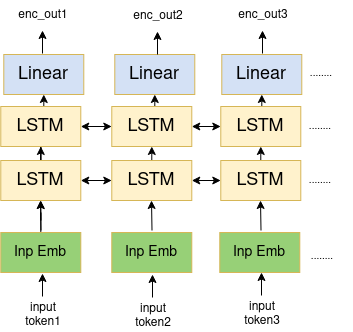

The **encoder** takes as input a tokenized version of the text transcription, where we feed in the indexes of the tokens corresponding to the input sentences (e.g., `"CONVERT ONE THIRD FLUID OUNCES TO GALLONS"`).

Next, we have input embeddings that convert these indexes to a set of high-dimensional vectors.

The encoder processes its inputs using two bidirectional LSTM layers. It's worth noting that we can use bidirectional networks in the encoder without any issues. Finally, we apply a linear layer that computes the final encoded outputs.

The **decoder** is the following:

**Decoder**

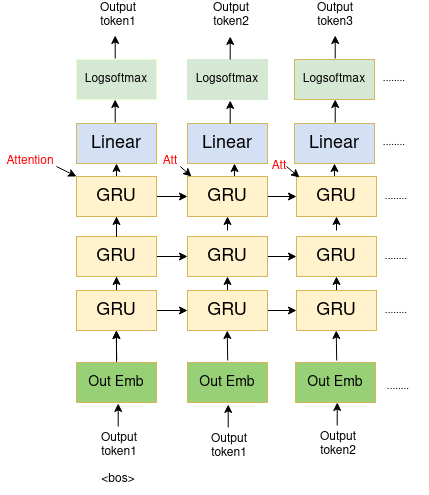

The **decoder** is a recurrent neural network that predicts the next token in a sequence based on the previous token. An attention mechanisms connects the last layers of the encoder and the decoder. In this case, the output sequence is an intent and associated slots, such the following one:

`['intent': 'UnitConversion', 'slots': ['unit1': 'fluid ounce', 'unit2': 'gallon', 'amount': 0.33]]`

To process the output sequence, we first use a tokenizer to convert the text of the semantic representations into a sequence of indices, and then map those indices to a high-dimensional vector using output embeddings.

The decoder consists of three layers of unidirectional GRUs, with the last layer incorporating attention mechanisms to connect the encoder output with the decoder. Finally, we apply a linear layer followed by a log softmax to generate the output probabilities.

During validation and testing, we use beamsearch to find the most likely output sequence based on the decoder output probabilities. To train the system, we use negative log-likelihood as the objective function.


First, let's train two tokenizers: one for the input transcription and another one for the output semantics.

**Run the following code** to get the hyperparameter file.

In [ ]:
%%file hparams_tokenizer.yaml

output_folder: !PLACEHOLDER
annotation_read: !PLACEHOLDER
annotation_file: "train.json"
vocab_size: 51

tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <annotation_file>
   annotation_read: !ref <annotation_read>
   annotation_format : "json"
   model_type: "unigram"

**Run the following code** to get the training script.

In [ ]:
%%file train_tokenizer.py

#!/usr/bin/env/python3
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main

if __name__ == "__main__":

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Train tokenizer
    hparams["tokenizer"]()

**Run the following code** to train the two tokenizers:

In [ ]:
!python train_tokenizer.py hparams_tokenizer.yaml --output_folder='/content/results/tokenizer/transcription/' --annotation_read='transcription'
!python train_tokenizer.py hparams_tokenizer.yaml --output_folder='/content/results/tokenizer/semantics/' --annotation_read='semantics'

Now, we can think about designing the sequence-to-sequence system described above. Note that this is very similar to other models already implemented in previous labs/tutorials (e.g, the speech recognition one).

To begin with, we need to define a hyperparameter file that includes the necessary modules for the training script. Please review the hyperparameter file and become familiar with the various components that are involved.


**Run the following code** to store the hyperparameter file.

In [ ]:
%%file hparams.yaml

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/NLU/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
train_json: train.json
valid_json: valid.json
test_json: test.json

tokenizer_semantics_file: /content/results/tokenizer/semantics/51_unigram.model
tokenizer_transcription_file: /content/results/tokenizer/transcription/51_unigram.model

# Training parameters
number_of_epochs: 15
batch_size: 16
lr: 0.001

# Model params
emb_size: 128
dec_neurons: 512
output_neurons: 51 # index(eos/bos) = 0
encoder_dim: 256

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 10.0
slu_beam_size: 16
eos_threshold: 1.5
temperature: 1.25

dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


encoder: !new:speechbrain.nnet.containers.Sequential
    input_shape: [null, null, !ref <emb_size>]
    lstm: !new:speechbrain.nnet.RNN.LSTM
        input_size: !ref <emb_size>
        bidirectional: True
        hidden_size: !ref <encoder_dim>
        num_layers: 2
    linear: !new:speechbrain.nnet.linear.Linear
        input_size: !ref <encoder_dim> * 2
        n_neurons: !ref <encoder_dim>

input_emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

output_emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <encoder_dim>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: content
    hidden_size: !ref <dec_neurons>
    attn_dim: 512
    num_layers: 3
    scaling: 1.0
    dropout: 0.0

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

modules:
    encoder: !ref <encoder>
    input_emb: !ref <input_emb>
    output_emb: !ref <output_emb>
    dec: !ref <dec>
    seq_lin: !ref <seq_lin>


model: !new:torch.nn.ModuleList
    - [!ref <encoder>, !ref <input_emb>, !ref <output_emb>,
       !ref <dec>, !ref <seq_lin>]

tokenizer_semantics: !new:sentencepiece.SentencePieceProcessor
tokenizer_transcription: !new:sentencepiece.SentencePieceProcessor

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>/tokenizers
    loadables:
        tokenizer_semantics: !ref <tokenizer_semantics>
        tokenizer_transcription: !ref <tokenizer_transcription>
    paths:
        tokenizer_semantics: !ref <tokenizer_semantics_file>
        tokenizer_transcription: !ref <tokenizer_transcription_file>

beam_searcher: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <output_emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <slu_beam_size>
    eos_threshold: !ref <eos_threshold>
    temperature: !ref <temperature>
    using_max_attn_shift: False
    max_attn_shift: 30

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

seq_cost: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: 0.1

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

Now, you need to write the training script. You can refer to similar models that have been implemented in previous labs or tutorials. The recommended approach is to copy and paste the relevant code from those models and modify it as needed in this lab.

**Note on performance metrics**:
Similar to the speech recognition, the performance of the sequence-to-sequence model can be evaluated using metrics such as the character error rate (CER) and the word-error-rate (WER). However, since this task involves generating output semantics, it is also recommended to estimate the sentence-error-rate (SER).

The SER can provide an overall indication of how many output semantics are completely correct, which is important for evaluating the model's effectiveness in real-world scenarios. To compute it, you can reuse the wer_metric function that you should instantiate in `on_stage_start` (`self.wer_metric = self.hparams.error_rate_computer()`). You simply have to call it as follows in the on_stage_end method: `stage_stats["SER"] = self.wer_metric.summarize("SER")`.


You need to perform the learning rate annealing based on the sentence-error-rate (SER). The SER have also to be used as a reference metric in the checkpoint.During evaluation, it is necessary to select the checkpoint with the lowest SER.


**Write the code** for the traning script.

In [ ]:
%%file train_NLU.py

# Your code here


**Run the code below** to train the model:

In [ ]:
!python train_NLU.py hparams.yaml --output_folder=results/NLU2/

If everything goes well, you should obtain a traning log similar to this one:

```
epoch: 1, lr: 1.00e-03 - train loss: 1.61 - valid loss: 9.02e-01, valid CER: 1.79e+02, valid WER: 1.63e+02, valid SER: 1.00e+02
epoch: 2, lr: 1.00e-03 - train loss: 8.52e-01 - valid loss: 8.23e-01, valid CER: 11.21, valid WER: 29.23, valid SER: 99.02
epoch: 3, lr: 1.00e-03 - train loss: 8.02e-01 - valid loss: 7.82e-01, valid CER: 7.08, valid WER: 17.93, valid SER: 80.88
epoch: 4, lr: 1.00e-03 - train loss: 7.54e-01 - valid loss: 7.43e-01, valid CER: 4.38, valid WER: 10.47, valid SER: 59.80
epoch: 5, lr: 1.00e-03 - train loss: 7.32e-01 - valid loss: 7.26e-01, valid CER: 3.32, valid WER: 5.78, valid SER: 39.22
epoch: 6, lr: 1.00e-03 - train loss: 7.21e-01 - valid loss: 7.14e-01, valid CER: 1.09, valid WER: 1.82, valid SER: 15.20
epoch: 7, lr: 1.00e-03 - train loss: 7.13e-01 - valid loss: 7.12e-01, valid CER: 3.58e-01, valid WER: 6.25e-01, valid SER: 5.88
epoch: 8, lr: 1.00e-03 - train loss: 7.09e-01 - valid loss: 7.08e-01, valid CER: 1.96e-01, valid WER: 3.13e-01, valid SER: 2.94
epoch: 9, lr: 1.00e-03 - train loss: 7.07e-01 - valid loss: 7.07e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 10, lr: 1.00e-03 - train loss: 7.06e-01 - valid loss: 7.06e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 11, lr: 8.00e-04 - train loss: 7.05e-01 - valid loss: 7.06e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 12, lr: 6.40e-04 - train loss: 7.05e-01 - valid loss: 7.06e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 13, lr: 5.12e-04 - train loss: 7.05e-01 - valid loss: 7.05e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 14, lr: 4.10e-04 - train loss: 7.05e-01 - valid loss: 7.05e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
epoch: 15, lr: 3.28e-04 - train loss: 7.05e-01 - valid loss: 7.05e-01, valid CER: 1.16e-02, valid WER: 1.04e-01, valid SER: 9.80e-01
Epoch loaded: 15 - test loss: 7.05e-01, test CER: 1.48e-02, test WER: 8.85e-02, test SER: 8.33e-01
```

You can take a look at the `wer.txt` file as well to double-check the quality of the predicted output.


At the end of the training process, the sentence-error-rate (SER) of the model on the test set should be very low, ideally between 0% and 1%. A low SER indicates that the model can accurately generate output semantics, meaning that the task can be solved almost perfectly.

## **Exercise 3: Sequence-to-Sequence with the ASR Transcription**

In the previous exercise, we used the ideal case of golden transcription as input. However, in real-world scenarios, speech recognition systems can introduce errors in the transcription. In this exercise, we will analyze the effect of ASR errors in the input transcription. The JSON file contains an entry called "asr_transcription" that includes the transcription of the input signal obtained from a basic ASR system.

For this exercise, you can copy-and-paste the code from Exercise 2 and make a small modification so that the system uses "asr_transcription" instead of "transcription" as input.


**Write the code** for traning the model with the ASR transcriptions:

In [ ]:
%%file train_NLU_ASR.py

# Your code here



**Run the code below** to train the model

In [ ]:
!python train_NLU_ASR.py hparams.yaml --output_folder=results/NLU_ASR/

If everything goes well, you should obtain the following training logs:



```
epoch: 1, lr: 1.00e-03 - train loss: 1.62 - valid loss: 9.12e-01, valid CER: 1.25e+02, valid WER: 1.21e+02, valid SER: 1.00e+02
epoch: 2, lr: 1.00e-03 - train loss: 8.59e-01 - valid loss: 8.33e-01, valid CER: 16.33, valid WER: 37.36, valid SER: 99.51
epoch: 3, lr: 1.00e-03 - train loss: 8.17e-01 - valid loss: 8.05e-01, valid CER: 11.64, valid WER: 25.69, valid SER: 92.16
epoch: 4, lr: 1.00e-03 - train loss: 7.86e-01 - valid loss: 7.75e-01, valid CER: 7.78, valid WER: 17.72, valid SER: 69.61
epoch: 5, lr: 1.00e-03 - train loss: 7.61e-01 - valid loss: 7.61e-01, valid CER: 6.74, valid WER: 14.85, valid SER: 64.22
epoch: 6, lr: 1.00e-03 - train loss: 7.49e-01 - valid loss: 7.53e-01, valid CER: 5.23, valid WER: 11.72, valid SER: 58.33
epoch: 7, lr: 1.00e-03 - train loss: 7.39e-01 - valid loss: 7.48e-01, valid CER: 3.40, valid WER: 8.39, valid SER: 43.14
epoch: 8, lr: 1.00e-03 - train loss: 7.30e-01 - valid loss: 7.42e-01, valid CER: 2.28, valid WER: 7.24, valid SER: 43.14
epoch: 9, lr: 8.00e-04 - train loss: 7.23e-01 - valid loss: 7.37e-01, valid CER: 2.56, valid WER: 6.93, valid SER: 36.76
epoch: 10, lr: 8.00e-04 - train loss: 7.19e-01 - valid loss: 7.37e-01, valid CER: 2.60, valid WER: 6.93, valid SER: 32.84
epoch: 11, lr: 8.00e-04 - train loss: 7.17e-01 - valid loss: 7.38e-01, valid CER: 2.02, valid WER: 6.15, valid SER: 35.29
epoch: 12, lr: 6.40e-04 - train loss: 7.14e-01 - valid loss: 7.36e-01, valid CER: 2.00, valid WER: 5.58, valid SER: 31.86
epoch: 13, lr: 6.40e-04 - train loss: 7.12e-01 - valid loss: 7.36e-01, valid CER: 1.89, valid WER: 5.94, valid SER: 34.31
epoch: 14, lr: 5.12e-04 - train loss: 7.10e-01 - valid loss: 7.36e-01, valid CER: 1.65, valid WER: 5.11, valid SER: 29.90
epoch: 15, lr: 5.12e-04 - train loss: 7.09e-01 - valid loss: 7.36e-01, valid CER: 1.70, valid WER: 5.16, valid SER: 30.39
Epoch loaded: 14 - test loss: 7.35e-01, test CER: 3.39, test WER: 7.12, test SER: 29.17

```






As you can see from the results, the sentence error rate has significantly increased due to the ASR errors in the input transcription.

## **Conclusion**

In this lab, we have learned how to train an NLU model on top of speech transcriptions. There are other strategies to improve performance. One approach is to jointly train the ASR and NLU models. Another approach gaining popularity is the end-to-end spoken language understanding, where a single model directly maps the input speech signals to the output semantics.

Moreover, modern systems take advantage of pre-trained self-supervised encoders to improve performance further. This dataset includes speech waveforms as well, and you can experiment with these modern approaches if you are interested in this topic.

That's all